# Ethiopia Crop Productivity Analysis

This notebook uses Enhanced Vegetation Index (EVI) from MODIS as a proxy for crop yield. EVI measures canopy greeness by analyzing spectral data through satellite imagery. EVI serves as a proxy for crop yield because it measures photosynthetic activity and green biomass, which strongly correlate with a crop's potential productivity and final harvest output. 

## Methodology Summary

1. Download imagery from MODIS for Ethiopia from 2012-2024. 
2. Get Crop Mask data for Ethiopia from Digital Earth Africa
3. Estimate area of crop land in each admin region 
4. Use 2021-2023 data as a baseline to identify growing season in Ethiopia
5. Use the growing season to track difference in EVI in 2024 compared to a 10 year average (2012-2022)
6. Plot trends in EVI over the last decade



In [77]:
import ee
import os

# Force reauthentication with proper scopes
ee.Authenticate()

# Then initialize with your project
ee.Initialize()


Successfully saved authorization token.


In [17]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../training-253313-c905674c1ca0.json"

In [18]:
import sys
#gee_zonal_module_path = r"D:/WB/GEE_Zonal/src"
#sys.path.append(gee_zonal_module_path)

# Now, import the zonal_stats and gee_helpers modules
#import zonalstats
#import gee_helpers
from gee_zonal import *
from gee_zonal import gee_helpers
import geopandas as gpd
import pandas as pd
import numpy as np
import ee
from geemap.conversion import *
import matplotlib.pyplot as plt
import requests
import rasterio
from rasterio.mask import mask
#from gee_helpers import gpd_to_gee
import json
import folium
import branca.colormap as cm
import importlib
import ast
import rasterio
from branca.colormap import LinearColormap
import base64
from io import BytesIO
#import calculate_areas


In [19]:
# loading boundaries 
eth_adm0 = gpd.read_file("../../data/boundaries/eth_admbnda_adm0_csa_bofedb_itos_2021.shp")
eth_adm1 = gpd.read_file("../../data/boundaries/eth_admbnda_adm1_csa_bofedb_2021.shp")
eth_adm2 = gpd.read_file("../../data/boundaries/eth_admbnda_adm2_csa_bofedb_2021.shp")
eth_adm3 = gpd.read_file("../../data/boundaries/eth_admbnda_adm3_csa_bofedb_2021.shp")

In [20]:
# Extracting centroid values
centroid = eth_adm0['geometry'].iloc[0].centroid
centy, centx = centroid.x, centroid.y

In [21]:
aoi_adm1 = gpd_to_gee(eth_adm1)

**MODIS**


We utilize Google Earth Engine to access the Enhanced Vegetation Index (EVI) band from the [MODIS satellite](https://modis.gsfc.nasa.gov/about/). By combining data from [Terra](https://lpdaac.usgs.gov/products/mod13q1v061/) and [Aqua](https://lpdaac.usgs.gov/products/myd13q1v061/), we obtain a map of EVI at 250 meters resolution every 16-days from 2012 to 2024. 

The enhanced vegetation index (EVI) is an 'optimized' vegetation index designed to enhance the vegetation signal with improved vegetation monitoring through a de-coupling of the canopy background signal and a reduction in atmosphere influences.

We apply the necessary data masking steps:
1. Mask out bad quality data (shadows/clouds)
2. Mask out non-crop areas using the ESA crop layer.

The ESA Layers have the following information. We pick 40 for cropland. All other agricultural land that could be in other categories has not been considered for this analysis. 
* **10**: Tree cover
* **20**: Shrubland  
* **30**: Grassland
* **40**: Cropland
* **50**: Built-up
* **60**: Bare / sparse vegetation
* **70**: Snow and ice
* **80**: Permanent water bodies
* **90**: Herbaceous wetland
* **95**: Mangroves
* **100**: Moss and lichen


In [40]:
eth_adm0.to_file("../../data/boundaries/ethiopia_adm0.geojson", driver='GeoJSON')


with open("../../data/boundaries/ethiopia_adm0.geojson") as f:
    eth_geometry = json.load(f)
eth_geometry = ee.Geometry(eth_geometry['features'][0]['geometry'])

In [69]:
#MODIS Data for EVI
start_period = ee.Date("2012-01-01")
end_period = ee.Date("2024-12-31")

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")

#----------------------BITWISE MASKING---------------------------------------
def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}

#Applying DEA Cropmask
dea = ee.ImageCollection(
    "projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/mask"
).mosaic()
crop_data_dea = dea.select("b1").rename("crop").clip(eth_geometry)
crop_data_viz_dea = crop_data_dea.mask(crop_data_dea.gt(0))


scale_factor = 0.0001

# apply cropland mask to imageCollection
def cropmask(img):
    return img.updateMask(crop_data_dea).clip(eth_geometry)  # .multiply(scale_factor) # unmask(-1)


mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)

In [70]:
bool_dict = {
    "0": "non_crop",
    "1": "crop",
}
#Number of crop pixels in each admin region

zs = ZonalStats(
    target_features=aoi_adm1,
    statistic_type="count",
    scale=10,
    ee_dataset=crop_data_dea,
    output_name="adm1_crop_count",
    output_dir="GEE_ETH",
)

In [71]:
zs.runZonalStats()

# Run this only when export is being done to GDrive
zs.reportRunTime()

Status is Ready, hasn't started


## Findings

### Croparea Statistics


In [47]:
adm1_cropcount_path = "../../data/agriculture/adm1_crop_count.csv"
df = pd.read_csv(adm1_cropcount_path)

def load_dict(input_str):
    input_str = input_str.replace("null", "'null'")
    input_str = input_str.replace("=", ":")
    result_dict = ast.literal_eval(input_str)
    return result_dict


df.loc[:, "histogram"] = df.apply(lambda x: load_dict(x["histogram"]), axis=1)

bool_dict = {
    0: "non_crop",
    1: "crop",
}
histograms = df["histogram"]
histograms_dfs = [
    pd.DataFrame(index=[idx], data=hist_dict) for idx, hist_dict in histograms.items()
]
histogram_df = pd.concat(histograms_dfs, axis=0).fillna(0)
histogram_df.rename(columns=bool_dict, inplace=True)

df = df.join(histogram_df)
df = df.sort_values(by="crop", ascending=False)
df.loc[:, "Crop Area ha."] = ((df["crop"] * 100) / 10000).apply(lambda x: f"{x:,.0f}")
df.loc[:, "Crop Area Share (% of Region)"] = (
    df["crop"] / (df["crop"] + df["non_crop"])
).apply(lambda x: f"{x:.2%}")
df.loc[:, "Crop Area Share (% of Country)"] = (df["crop"] / (df["crop"].sum())).apply(
    lambda x: f"{x:.2%}"
)
df.rename(columns={"ADM1_EN": "Region"}, inplace=True)
df[
    [
        "Region",
        "Crop Area ha.",
        "Crop Area Share (% of Country)",
        "Crop Area Share (% of Region)",
    ]
].reset_index(drop=True)

,Region,Crop Area ha.,Crop Area Share (% of Country),Crop Area Share (% of Region)
0,Oromia,"10,090,333",42.00%,36.55%
1,Amhara,"6,429,973",26.76%,48.91%
2,SNNP,"2,298,187",9.57%,41.02%
3,Tigray,"2,092,136",8.71%,44.66%
4,South West Ethiopia,"1,343,857",5.59%,41.75%
5,Benishangul Gumz,"918,617",3.82%,18.78%
6,Sidama,"349,321",1.45%,53.70%
7,Gambela,"191,895",0.80%,7.19%
8,Somali,"175,187",0.73%,0.58%
9,Afar,"106,551",0.44%,1.18%


In [48]:
crop_admin_regions = df.sort_values(by="crop", ascending=False)['Region'].head(6).to_list()

In [49]:
aoi = gpd_to_gee(eth_adm0)

In [50]:
mxd13q1_recent = mxd13q1.filterDate("2019-01-01", "2024-12-31")

zs = ZonalStats(
    ee_dataset=mxd13q1_recent,          # this is your EVI time series
    target_features=aoi,
    statistic_type="median",
    scale=250,
    output_name="eth_phenology",
    output_dir="GEE_ETH"
)

zs.runZonalStats()

# Convert to phenology_df structure
#phenology_df = evi_df.pivot(index="date", columns="region", values="mean")


In [51]:
evi_df = pd.read_csv('../../data/agriculture/eth_phenology.csv')

In [57]:
# Step 1: Keep only EVI columns and metadata
evi_columns = [col for col in evi_df.columns if "_EVI" in col]
meta_columns = ['ADM0_EN', 'ADM0_PCODE']  # Adjust as needed
df_subset = evi_df[meta_columns + evi_columns]

# Step 2: Melt into long format
df_long = df_subset.melt(id_vars=meta_columns, 
                         value_vars=evi_columns,
                         var_name="band_date", 
                         value_name="EVI")

# Step 3: Extract proper date
df_long["date"] = pd.to_datetime(df_long["band_date"].str.extract(r'(\d{4}_\d{2}_\d{2})')[0], format="%Y_%m_%d")

# Optional: Clean region label
df_long.rename(columns={"ADM0_EN": "region"}, inplace=True)

phenology_df = df_long.pivot(index="date", columns="region", values="EVI")


In [58]:
#scaling factor for MODIS
phenology_df = phenology_df/10000

In [59]:
from scipy.signal import savgol_filter

def preprocess_series(series):
    """TIMESAT-style preprocessing."""
    series = series.interpolate(limit_direction="both")  # Step 2: Interpolate
    median = series.rolling(window=5, center=True).median()
    std_dev = series.std()
    series = series.mask((series - median).abs() > 2 * std_dev)  # Step 1: Remove outliers
    series = series.interpolate(limit_direction="both")
    smoothed = savgol_filter(series, window_length=5, polyorder=2)  # Step 3: Smooth
    return smoothed

def extract_sos_mos_eos(smoothed, dates, threshold=0.2):
    max_val = smoothed.max()
    min_val = smoothed.min()
    amp = max_val - min_val
    sos = mos = eos = None
    for i in range(1, len(smoothed)):
        if sos is None and smoothed[i] > min_val + threshold * amp:
            sos = dates[i]
        if smoothed[i] == max_val:
            mos = dates[i]
        if sos is not None and smoothed[i] < min_val + threshold * amp:
            eos = dates[i]
            break
    return sos, mos, eos


In [60]:
monthly_df = phenology_df.copy()
monthly_df["month"] = monthly_df.index.month
monthly_df = monthly_df.groupby("month").mean()

In [63]:
season_dict = {}

for region in monthly_df.columns:
    series = monthly_df[region]
    smoothed = preprocess_series(series)
    sos, mos, eos = extract_sos_mos_eos(smoothed, monthly_df.index)
    #print(sos, region, eos)
    season_dict[region] = {"SOS": sos, "MOS": mos, "EOS": eos}
    #print(f"{region}: SOS={sos.date()}, MOS={mos.date()}, EOS={eos.date()}")


### Crop Seasonality
Using this time series dataset of EVI images, we apply several pre-processing steps to extract critical phenological parameters: start of season (SOS), middle of season (MOS), end of season (EOS), length of season (LOS), etc. This workflow is heavily inspired by the [TIMESAT](https://web.nateko.lu.se/timesat/timesat.asp) software, although in this implementation we use the [Phenolopy](https://github.com/frontiersi/phenolopy/tree/main) open-source package.  

**Pre-processing steps**  
1. Remove outliers from dataset on per-pixel basis using median method: outlier if median from a moving window < or > standard deviation of time-series times 2.
2. Interpolate missing values linearly
3. Smooth data on per-pixel basis (using Savitsky Golay filter, window length of 3, and polyorder of 1)  

**Phenology Process**  
We then extract crop seasonality metrics using the seasonal amplitude method from the phenolopy package. 

The chart below shows the result of this process for a single crop pixel. The green dots represent the raw EVI values, the black line represents the processed EVI values, and the red dotted lines represent season parameters extracted for that pixel: start of season, peak of season, and end of season.

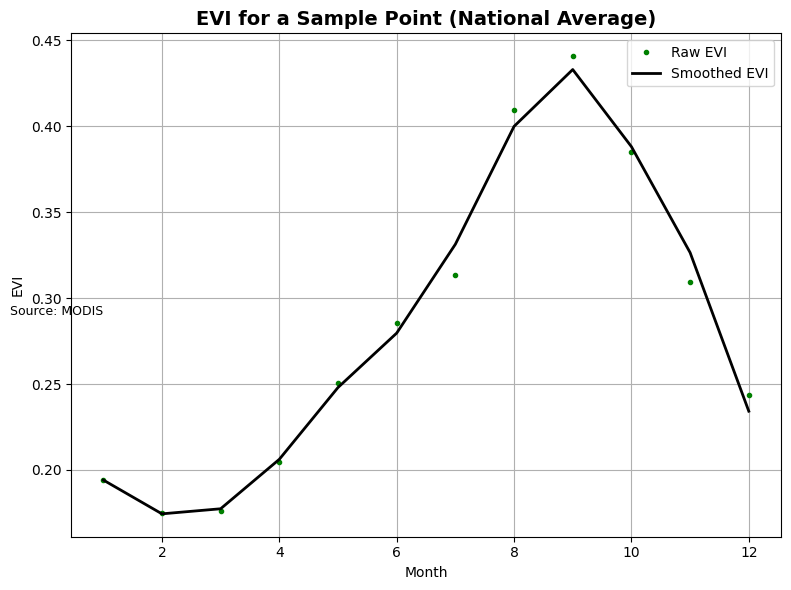

In [68]:
df = monthly_df

plt.figure(figsize=(8, 6))
plt.plot(df.index, df, 'o', color='green', markersize=3, label="Raw EVI")
plt.plot(df.index, smoothed, 'k-', linewidth=2, label="Smoothed EVI")
# for date in [sos, mos, eos]:
#     plt.axvline(date, color='red', linestyle='--')
plt.title("EVI for a Sample Point (National Average)", fontsize=14, weight='bold')
plt.ylabel("EVI")
plt.xlabel("Month")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.text(df.index[0], 0.29, "Source: MODIS", fontsize=9, ha='right')
plt.savefig('../../docs/images/agriculture/season.png', dpi=300, bbox_inches='tight')
plt.show()



**Based on the phenology process, we identified the seasonality to start in April/May and end in December with the peak being in September.** This can vary with geographic region and crop type as well, however, that has not been taken into consideration in this version. 

In [72]:
growing_season = ee.Filter.calendarRange(4, 11, 'month')

# Calculate mean EVI for 2012-2022 growing seasons
gs_evi_10yr_avg = mxd13q1.filterDate('2012-01-01', '2022-12-31').filter(growing_season).mean().clip(eth_geometry)

# Calculate mean EVI for the 2023 growing season
gs_evi_2023 = mxd13q1.filterDate('2023-01-01', '2023-12-31').filter(growing_season).mean().clip(eth_geometry)

# Calculate mean EVI for the 2024 growing season
gs_evi_2024 = mxd13q1.filterDate('2024-01-01', '2024-12-31').filter(growing_season).mean().clip(eth_geometry)

# Calculate the difference between 2023 EVI and the 10-year average
evi_diff_2023 = gs_evi_2023.subtract(gs_evi_10yr_avg).rename('EVI_Difference')
evi_diff_2024 = gs_evi_2024.subtract(gs_evi_10yr_avg).rename('EVI_Difference')

In [74]:
# Define growing season filter
growing_season = ee.Filter.calendarRange(4, 11, 'month')

# Define function to calculate EVI z-score for a given year
def calculate_evi_zscore(year, mxd13q1, historical_median, historical_stddev, haiti_geometry):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Calculate median EVI for the year's growing season
    year_evi = mxd13q1.filterDate(start_date, end_date) \
                      .filter(growing_season) \
                      .median() \
                      .clip(haiti_geometry)
    
    # Calculate Z-score: (current - median) / stdDev
    evi_zscore = year_evi.subtract(historical_median) \
                         .divide(historical_stddev) \
                         .rename('EVI_ZScore')
    
    return evi_zscore

# Calculate historical reference (2012-2022)
# Calculate median EVI for 2012-2022 growing seasons
gs_evi_10yr_med = mxd13q1.filterDate('2012-01-01', '2022-12-31') \
                         .filter(growing_season) \
                         .median() \
                         .clip(eth_geometry)

gs_evi_5yr_med = mxd13q1.filterDate('2012-01-01', '2017-12-31') \
                         .filter(growing_season) \
                         .median() \
                         .clip(eth_geometry)

# Calculate standard deviation of EVI for 2012-2022 growing seasons
historical_collection = mxd13q1.filterDate('2012-01-01', '2022-12-31') \
                               .filter(growing_season) \
                               .select('EVI')

historical_collection_5yr = mxd13q1.filterDate('2012-01-01', '2017-12-31') \
                               .filter(growing_season) \
                               .select('EVI')
                               
gs_evi_10yr_stdDev = historical_collection.reduce(ee.Reducer.stdDev()).clip(eth_geometry)
gs_evi_5yr_stdDev = historical_collection.reduce(ee.Reducer.stdDev()).clip(eth_geometry)

# Calculate z-scores for multiple years using a loop
years = [2019, 2020, 2021, 2022, 2023, 2024]
evi_zscores = {}
evi_zscores_5yr = {}

for year in years:
    evi_zscores[year] = calculate_evi_zscore(year, mxd13q1, gs_evi_10yr_med, 
                                           gs_evi_10yr_stdDev, eth_geometry)
    
    evi_zscores_5yr[year] = calculate_evi_zscore(year, mxd13q1, gs_evi_5yr_med, 
                                           gs_evi_5yr_stdDev, eth_geometry)

# Access individual z-scores as needed
# Examples:
# evi_zscore_2023 = evi_zscores[2023]
# evi_zscore_2024 = evi_zscores[2024]

In [75]:
# # Set up GCS export parameters
# 

def export_to_gcs(image, bucket_name, gcs_file_name, region=eth_geometry):

    # Create the GCS export task
    export_task = ee.batch.Export.image.toCloudStorage(
        image=image,
        description=gcs_file_name,
        bucket=bucket_name,
        fileNamePrefix=gcs_file_name,
        scale=250,
        region=eth_geometry,
        maxPixels=1e9
    )

    export_task.start()

    import time
    while export_task.status()['state'] in ['READY', 'RUNNING']:
        print(f"Task status: {export_task.status()['state']}")
        time.sleep(30)  # Check every 30 seconds

    print(f"Task complete with state: {export_task.status()['state']}")


In [79]:
# Define the bucket name
bucket_name = "datapartnership-agriculture"

# Create a dictionary of all files to export
export_files = {
    # Z-scores
    "evi_zscore_2019": evi_zscores[2019],
    "evi_zscore_2020": evi_zscores[2020],
    "evi_zscore_2021": evi_zscores[2021],
    "evi_zscore_2022": evi_zscores[2022],
    "evi_zscore_2023": evi_zscores[2023],
    "evi_zscore_2024": evi_zscores[2024],
    # "evi_zscore_5y_2018": evi_zscores_5yr[2018],
    # "evi_zscore_5y_2019": evi_zscores_5yr[2019],
    # "evi_zscore_5y_2020": evi_zscores_5yr[2020],
    # "evi_zscore_5y_2021": evi_zscores_5yr[2021],
    # "evi_zscore_5y_2022": evi_zscores_5yr[2022],
    # "evi_zscore_5y_2023": evi_zscores_5yr[2023],
    # "evi_zscore_5y_2024": evi_zscores_5yr[2024],
}

# Loop through the dictionary and export each file
# for file_name, data in export_files.items():
#     print(f"Exporting {file_name} to GCS...")
#     export_to_gcs(data, bucket_name, file_name)
#     print(f"Export task for {file_name} started")

# print("All export tasks have been started")

In [80]:
from google.cloud import storage

for gcs_file_name in list(export_files.keys()):
    # 
    storage_client = storage.Client()
    bucket = storage_client.bucket("datapartnership-agriculture")

    blob = bucket.blob(f"{gcs_file_name}.tif")
    output_path = f'../../docs/images/agriculture/{gcs_file_name}.tif'
    blob.download_to_filename(output_path)

    print(f"Downloaded {gcs_file_name}.tif to {output_path}")

Downloaded evi_zscore_2019.tif to ../../docs/images/agriculture/evi_zscore_2019.tif
Downloaded evi_zscore_2020.tif to ../../docs/images/agriculture/evi_zscore_2020.tif
Downloaded evi_zscore_2021.tif to ../../docs/images/agriculture/evi_zscore_2021.tif
Downloaded evi_zscore_2022.tif to ../../docs/images/agriculture/evi_zscore_2022.tif
Downloaded evi_zscore_2023.tif to ../../docs/images/agriculture/evi_zscore_2023.tif
Downloaded evi_zscore_2024.tif to ../../docs/images/agriculture/evi_zscore_2024.tif


### Anomalies in EVI

Anomalies are calculated using z score values. 

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ is the z-score (standard score)
- $x$ is the individual median EVI value
- $\mu$ is the mean of the median EVI values
- $\sigma$ is the standard deviation of the median EVI values

The higher the variation the greater the anomaly i.e., if the value is -1 then the EVI for that time period is far lesser than the normal and vice versa. 

The Z scores are calculated for 2023 and 2024 compared to a historic 10 year average. They are then displayed as a histogram, a map and an aggregated map. 

In [81]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def plot_zscore_histograms(*file_paths, labels=None, colors=None, output_path=None):
    """
    Create histograms from EVI z-score TIF files for multiple years.
    
    Parameters:
    *file_paths: Variable number of z-score TIF file paths
    labels: List of labels for each file (optional, defaults to file names)
    colors: List of colors for each file (optional, defaults to seaborn palette)
    output_path: Path to save the output figure (optional)
    """
    # Validate input
    if len(file_paths) == 0:
        raise ValueError("At least one file path must be provided")
    
    # Set default labels if not provided
    if labels is None:
        labels = [f"File {i+1}" for i in range(len(file_paths))]
    
    # Set default colors if not provided
    if colors is None:
        # Use a qualitative color palette from seaborn
        colors = sns.color_palette("husl", len(file_paths))
    
    # Validate that we have the right number of labels and colors
    if len(labels) != len(file_paths):
        raise ValueError(f"Number of labels ({len(labels)}) must match number of files ({len(file_paths)})")
    if len(colors) != len(file_paths):
        raise ValueError(f"Number of colors ({len(colors)}) must match number of files ({len(file_paths)})")
    
    # Read and process all files
    all_zscore_data = []
    all_stats = []
    
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            zscore_data = src.read(1)
            nodata = src.nodata
        
        # Filter out nodata values
        if nodata is not None:
            zscore_data = zscore_data[zscore_data != nodata]
        
        # Filter out extreme outliers (optional)
        # This keeps values between -5 and 5 standard deviations
        zscore_data = zscore_data[(zscore_data >= -5) & (zscore_data <= 5)]
        
        # Calculate key statistics
        stats = {
            'mean': np.mean(zscore_data),
            'median': np.median(zscore_data),
            'std': np.std(zscore_data),
            'significant_negative': np.sum(zscore_data < -1.96) / len(zscore_data) * 100,
            'significant_positive': np.sum(zscore_data > 1.96) / len(zscore_data) * 100
        }
        
        all_zscore_data.append(zscore_data)
        all_stats.append(stats)
    
    # Create a figure
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot all histograms on the same axes
    for i, (zscore_data, label, color) in enumerate(zip(all_zscore_data, labels, colors)):
        sns.histplot(zscore_data, kde=True, bins=50, color=color, alpha=0.5, 
                    label=label, ax=axes, stat='density')
    
    # Add reference lines
    axes.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Mean')
    axes.axvline(x=-1.96, color='red', linestyle='--', alpha=0.7, 
                label='Significantly Below Normal')
    axes.axvline(x=1.96, color='green', linestyle='--', alpha=0.7, 
                label='Significantly Above Normal')
    
    # Set labels and title
    axes.set_title('Comparison of EVI Z-Score Distributions', fontsize=16)
    axes.set_xlabel('Z-Score', fontsize=14)
    axes.set_ylabel('Density', fontsize=14)
    axes.legend(loc='upper right', frameon=True, framealpha=0.9)
    
    # Add grid
    axes.grid(axis='y', alpha=0.3)
    
    # Generate interpretation text
    interpretation_lines = []
    
    # Find year with highest and lowest mean
    means = [stats['mean'] for stats in all_stats]
    max_idx = np.argmax(means)
    min_idx = np.argmin(means)
    
    if max_idx != min_idx:
        if all_stats[max_idx]['mean'] > 0:
            interpretation_lines.append(f"{labels[max_idx]} shows the highest vegetation vigor")
        if all_stats[min_idx]['mean'] < 0:
            interpretation_lines.append(f"{labels[min_idx]} shows the most stressed vegetation")
    
    # Overall condition assessment
    below_normal_count = sum(1 for stats in all_stats if stats['mean'] < 0)
    above_normal_count = sum(1 for stats in all_stats if stats['mean'] > 0)
    
    if below_normal_count > above_normal_count:
        interpretation_lines.append("Overall trend shows below-normal vegetation conditions")
    elif above_normal_count > below_normal_count:
        interpretation_lines.append("Overall trend shows above-normal vegetation conditions")
    else:
        interpretation_lines.append("Mixed vegetation conditions across the years")
    
    # # Add interpretation text
    # if interpretation_lines:
    #     interpretation_text = ". ".join(interpretation_lines) + "."
    #     axes.text(0.5, 0.05, interpretation_text,
    #                 transform=axes.transAxes, fontsize=11, ha='center',
    #                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    #                 wrap=True)
    
    # Print statistics summary
    print("\nStatistical Summary:")
    print("-" * 80)
    print(f"{'File':<40} {'Mean':>10} {'Median':>10} {'Std':>10} {'-1.96%':>10} {'+1.96%':>10}")
    print("-" * 80)
    for label, stats in zip(labels, all_stats):
        print(f"{label:<40} {stats['mean']:>10.3f} {stats['median']:>10.3f} "
              f"{stats['std']:>10.3f} {stats['significant_negative']:>10.1f} "
              f"{stats['significant_positive']:>10.1f}")
    print("-" * 80)
    
    # Save the figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

#


Statistical Summary:
--------------------------------------------------------------------------------
File                                           Mean     Median        Std     -1.96%     +1.96%
--------------------------------------------------------------------------------
2023                                          0.246      0.228      0.323        0.0        0.0
2024                                          0.156      0.118      0.370        0.0        0.1
--------------------------------------------------------------------------------


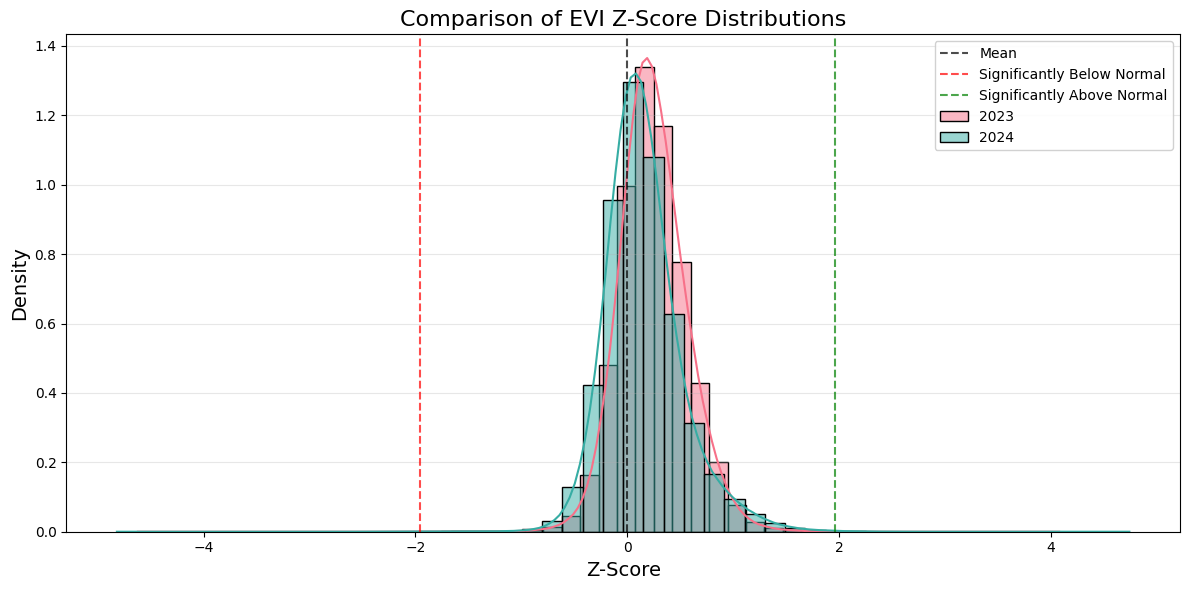

In [82]:
plot_zscore_histograms('../../docs/images/agriculture/evi_zscore_2023.tif',
                        '../../docs/images/agriculture/evi_zscore_2024.tif',
                          
                          labels =['2023', '2024'])


Statistical Summary:
--------------------------------------------------------------------------------
File                                           Mean     Median        Std     -1.96%     +1.96%
--------------------------------------------------------------------------------
2022                                         -0.152     -0.124      0.312        0.0        0.0
2021                                         -0.007     -0.010      0.249        0.0        0.0
--------------------------------------------------------------------------------


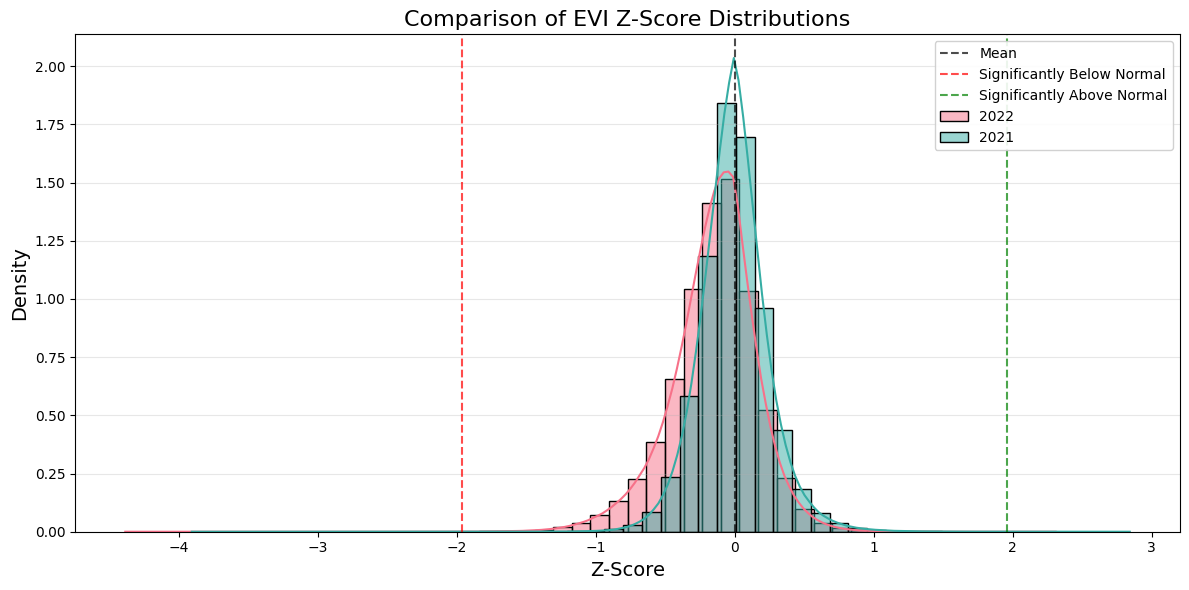

In [83]:
plot_zscore_histograms('../../docs/images/agriculture/evi_zscore_2022.tif',
                        '../../docs/images/agriculture/evi_zscore_2021.tif',
                          
                          labels =['2022', '2021'])

In [86]:
import geopandas as gpd
import numpy as np
from rasterstats import zonal_stats

def aggregate_zscores(raster_path, adm1):
    """Aggregate pixel Z-scores to ADM1 regions"""
    # Load admin boundaries
    #adm1 = gpd.read_file(adm1_path)
    
    # Calculate zonal statistics
    stats = zonal_stats(
        adm1,
        raster_path,
        stats=['mean', 'median', 'min', 'max', 'std', 'count'],
        geojson_out=True
    )
    
    # Convert to GeoDataFrame
    result = gpd.GeoDataFrame.from_features(stats)
    
    # Add original attributes
    for col in ['ADM1_EN']:
        if col in adm1.columns:
            result[col] = adm1[col].values
    
    return result

def plot_zscore_maps(gdfs, stat='mean', titles=None, figsize_per_plot=(8, 4), main_title='EVI Z-Score'):
    """
    Plot aggregated Z-scores by region for multiple GeoDataFrames
    
    Parameters:
    gdfs: List of GeoDataFrames to plot
    stat: Single statistic to plot for each GDF (default 'mean')
    titles: Optional list of titles for each plot (default None)
    figsize_per_plot: Size of each individual plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # If gdfs is not a list, convert it to one
    if not isinstance(gdfs, list):
        gdfs = [gdfs]
    
    # Calculate number of plots and grid dimensions
    n_plots = len(gdfs)
    
    # Calculate grid layout
    if n_plots == 1:
        nrows, ncols = 1, 1
    elif n_plots == 2:
        nrows, ncols = 1, 2
    elif n_plots <= 4:
        nrows, ncols = 2, 2
    elif n_plots <= 6:
        nrows, ncols = 2, 3
    else:
        # For more than 6, use a 3 column layout
        ncols = 3
        nrows = int(np.ceil(n_plots / ncols))
    
    # Create figure with appropriate size
    width = figsize_per_plot[0] * ncols
    height = figsize_per_plot[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(width, height))
    
    # Handle case where axes is not a 2D array
    if n_plots == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = axes.reshape(nrows, ncols)
    
    # Generate default titles if none provided
    if titles is None:
        titles = [f'EVI Z-Score by Region {i+1}' for i in range(n_plots)]
    elif len(titles) < n_plots:
        # Extend titles list if needed
        titles.extend([f'EVI Z-Score by Region {i+1}' for i in range(len(titles), n_plots)])
    
    # Plot each GeoDataFrame
    for idx, gdf in enumerate(gdfs):
        row_idx = idx // ncols
        col_idx = idx % ncols
        ax = axes[row_idx, col_idx]
        
        if stat in gdf.columns:
            gdf.plot(column=stat, cmap='BrBG', linewidth=0.5, 
                    edgecolor='0.5', legend=True, ax=ax, vmin=-3, vmax=3)
            ax.set_title(titles[idx])
        else:
            # If stat not found, show empty plot with message
            ax.text(0.5, 0.5, f'"{stat}" not found in GDF {idx+1}', 
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title(f'Missing: {stat} in {titles[idx]}')
        
        ax.set_axis_off()
    
    # Remove any unused subplots
    for idx in range(n_plots, nrows * ncols):
        row_idx = idx // ncols
        col_idx = idx % ncols
        fig.delaxes(axes[row_idx, col_idx])

    plt.suptitle(main_title, fontsize=16, weight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

c:\WBG\Anaconda3\envs\acled\Lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


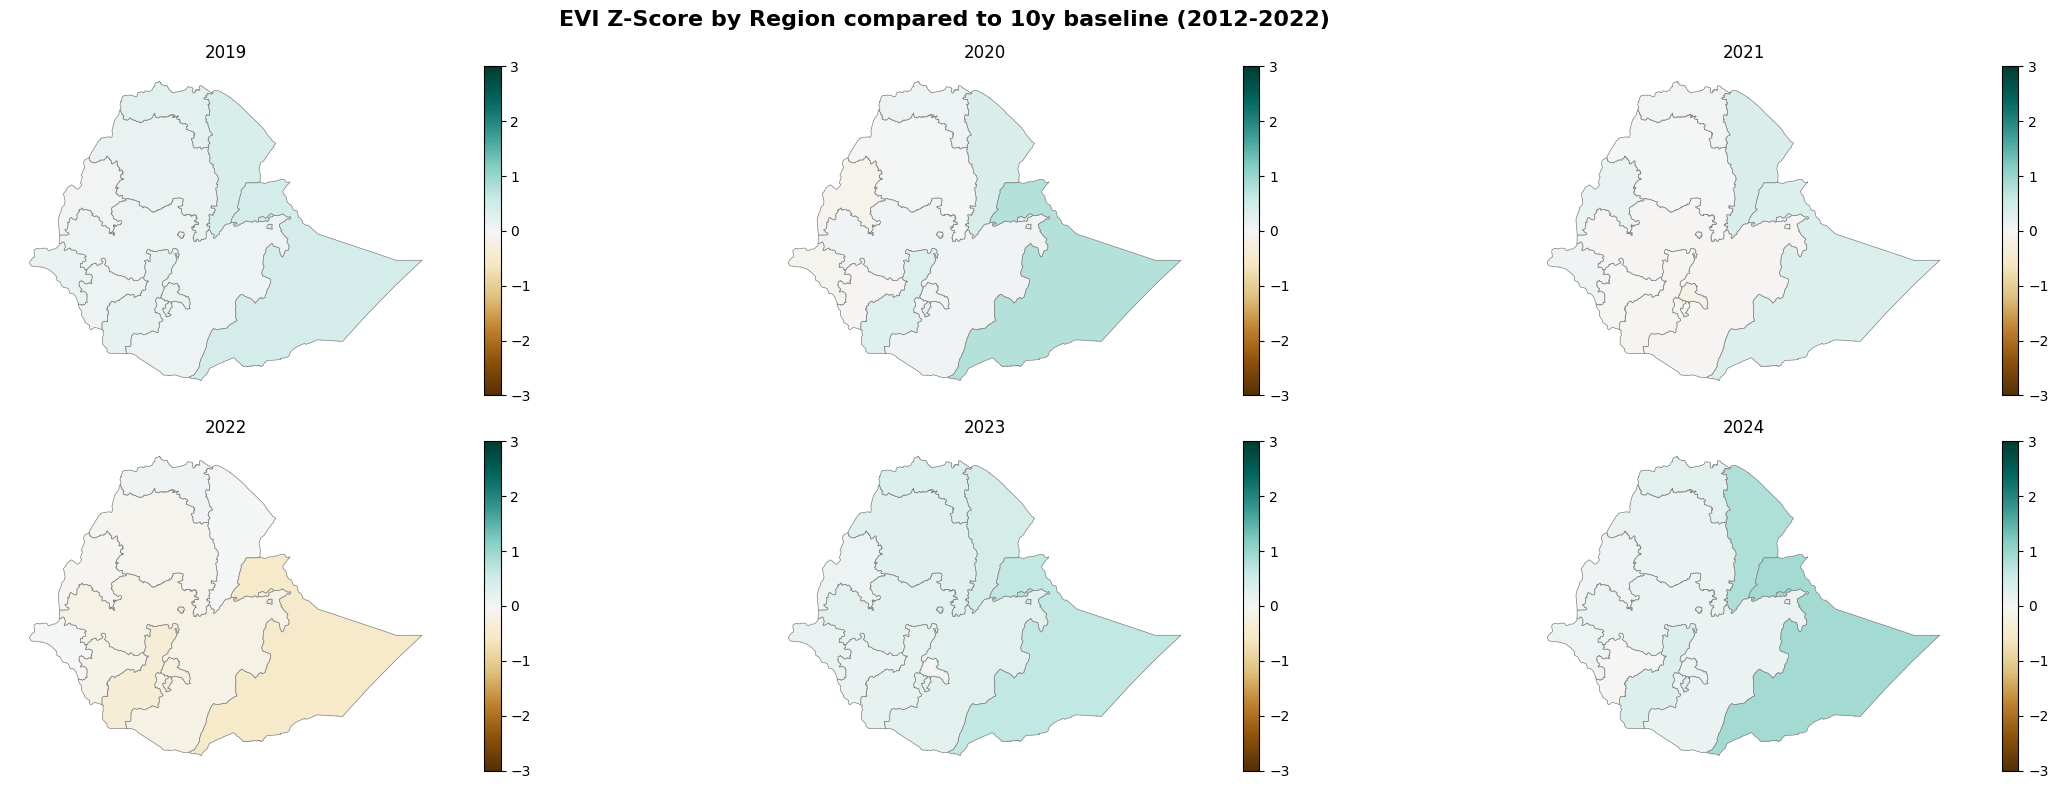

In [88]:
zscore_gdfs = []

for year in range(2019, 2025):
    zscore_gdf = aggregate_zscores(f'../../docs/images/agriculture/evi_zscore_{year}.tif', eth_adm1)
    zscore_gdfs.append(zscore_gdf)
fig = plot_zscore_maps(zscore_gdfs, titles = [2019,2020,2021,2022,2023,2024], main_title='EVI Z-Score by Region compared to 10y baseline (2012-2022)')


Loaded data for years: [2019, 2020, 2021, 2022, 2023, 2024]


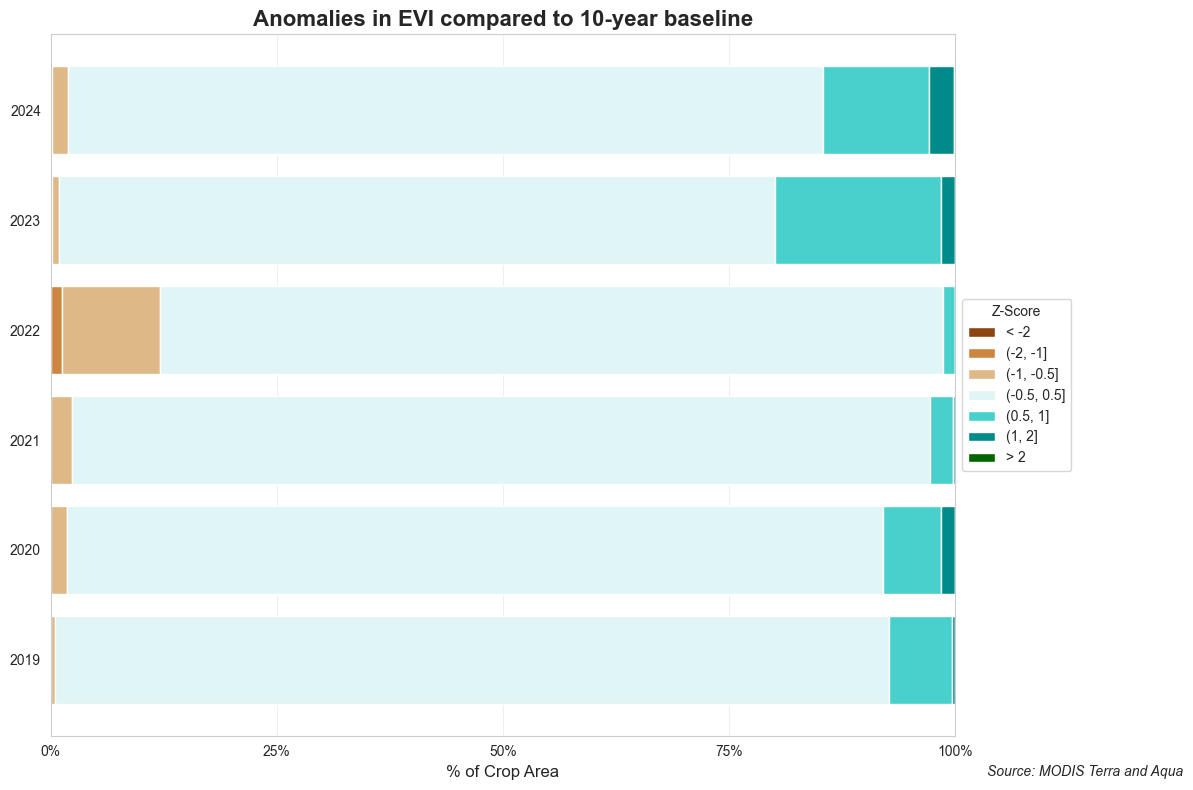

In [153]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import LinearSegmentedColormap

def read_tif_files(pattern='../../docs/images/agriculture/evi_zscore_*.tif'):
    """
    Read all TIF files matching the pattern and return a dictionary
    with year as key and array data as value
    """
    files = sorted(glob.glob(pattern))
    data_dict = {}
    
    for file in files:
        # Extract year from filename
        year = file.split('_')[-1].split('.')[0]
        
        # Read the raster file
        with rasterio.open(file) as src:
            data = src.read(1)  # Read first band
            
            # Handle NoData values
            if src.nodata is not None:
                mask = data != src.nodata
                valid_data = data[mask]
            else:
                valid_data = data[~np.isnan(data)]
            
            data_dict[int(year)] = valid_data
    
    return data_dict

def calculate_zscore_percentages(data_dict):
    """
    Calculate the percentage of area in each Z-score bin for each year
    """
    # Define Z-score bins
    bins = [float('-inf'), -2, -1, -0.5, 0.5, 1, 2, float('inf')]
    bin_labels = ['< -2', '(-2, -1]', '(-1, -0.5]', '(-0.5, 0.5]', 
                  '(0.5, 1]', '(1, 2]', '> 2']
    
    results = {}
    
    for year, zscores in data_dict.items():
        # Calculate percentages for each bin
        percentages = []
        total_count = len(zscores)
        
        for i in range(len(bins) - 1):
            if i == 0:  # First bin (< -2)
                count = np.sum(zscores < bins[i+1])
            elif i == len(bins) - 2:  # Last bin (> 2)
                count = np.sum(zscores > bins[i])
            else:  # Middle bins
                count = np.sum((zscores > bins[i]) & (zscores <= bins[i+1]))
            
            percentage = (count / total_count) * 100 if total_count > 0 else 0
            percentages.append(percentage)
        
        results[year] = percentages
    
    return results, bin_labels

def plot_productivity_anomalies(data_dict, title="Anomalies in Agricultural Productivity (EVI)"):
    """
    Create a stacked bar chart showing Z-score percentages by year
    """
    results, bin_labels = calculate_zscore_percentages(data_dict)
    
    # Convert to DataFrame
    df = pd.DataFrame(results, index=bin_labels).T
    df.sort_index(inplace=True)
    
    # Define colors for each Z-score range
    colors = ['#8B4513', '#CD853F', '#DEB887', '#E0F5F5', '#48D1CC', '#008B8B', '#006400']
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create stacked horizontal bars
    bars = ax.barh(df.index.astype(str), df.iloc[:, 0], color=colors[0], label=bin_labels[0])
    
    for i in range(1, len(bin_labels)):
        ax.barh(df.index.astype(str), df.iloc[:, i], 
                left=df.iloc[:, :i].sum(axis=1), 
                color=colors[i], label=bin_labels[i])
    
    # Set labels and title
    ax.set_xlabel('% of Crop Area', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Set x-axis limits and format
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    # Add grid
    ax.grid(axis='x', alpha=0.3)
    
    # Create custom legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), 
              title='Z-Score', fontsize=10)
    
    # Add source text
    plt.figtext(0.99, 0.02, 'Source: MODIS Terra and Aqua', ha='right', va='bottom', 
                fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    
    return fig, ax

# Example usage
if __name__ == "__main__":
    # Read all TIF files
    data_dict = read_tif_files('../../docs/images/agriculture/evi_zscore_*.tif')
    
    # Check if data was loaded
    if not data_dict:
        print("No TIF files found. Make sure the files are in the current directory.")
        print("Files should be named like: evi_zscore_2014.tif, evi_zscore_2015.tif, etc.")
    else:
        print(f"Loaded data for years: {sorted(data_dict.keys())}")
        
        # Create the plot
        fig, ax = plot_productivity_anomalies(data_dict, title = 'Anomalies in EVI compared to 10-year baseline')
        
        # Save the plot
        plt.savefig('../../docs/images/agriculture/agricultural_productivity_anomalies_10y_baseline.png', dpi=300, bbox_inches='tight')
        
        # Show the plot
        plt.show()

### Trends in Median EVI

In [ ]:
# Filter to reduce data volume (e.g., just get one composite per month)
for year in range(2012, 2025):

    filtered_mxd13q1 = mxd13q1.filter(
            ee.Filter.calendarRange(year, year, 'year')
        )

    zs = ZonalStats(
        ee_dataset=filtered_mxd13q1,
        target_features=eth_adm0,
        statistic_type="median",
        scale=250,
        output_name=f"eth_evi_adm0_median_{year}",
        output_dir="GEE_ETH",
        scale_factor=0.0001,
        tile_scale=4
    )

    zs.runZonalStats()


In [96]:
# Filter to reduce data volume (e.g., just get one composite per month)
for year in range(2012, 2018):

    filtered_mxd13q1 = mxd13q1.filter(
            ee.Filter.calendarRange(year, year, 'year')
        )

    zs = ZonalStats(
        ee_dataset=filtered_mxd13q1,
        target_features=eth_adm1,
        statistic_type="median",
        scale=250,
        output_name=f"eth_evi_adm1_median_{year}",
        output_dir="GEE_ETH",
        scale_factor=0.0001,
        tile_scale=4
    )

    zs.runZonalStats()


In [116]:
import glob
import os
import pandas as pd

def process_evi_files(input_dir, output_dir, evi_files):
    
    # List to hold all transformed dataframes
    all_transformed_data = []
    
    # Track which admin level we're processing
    admin_level = None

    for file_path in evi_files:
        print(f"Processing {os.path.basename(file_path)}...")
        
        try:
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Create an empty list to hold the transformed rows
            transformed_data = []
            
            # Identify EVI columns (those ending with _EVI)
            evi_columns = [col for col in df.columns if col.endswith('_EVI')]
            
            # Identify shape/geography columns - look for both ADM0_EN and ADM1_EN
            shape_columns = ['system:index', 'ADM0_EN', 'ADM1_EN', 'ADM0_PCODE', 'ADM0ALT1EN', 'ADM0ALT2EN', 
                            'ADM0_REF', 'Shape_Area', 'Shape_Leng', 'validOn', 'validTo']
            # Keep only columns that exist in the dataframe
            shape_columns = [col for col in shape_columns if col in df.columns]
            
            # Determine admin level for this file
            if 'ADM1_EN' in df.columns:
                admin_level = 'adm1'
            elif 'ADM0_EN' in df.columns:
                admin_level = 'adm0'
            else:
                admin_level = 'unknown'
                print(f"Warning: Could not determine admin level for {file_path}")
            
            # For each row in the original dataframe
            for _, row in df.iterrows():
                # Get admin area based on detected level
                if admin_level == 'adm1' and pd.notna(row['ADM1_EN']):
                    admin_area = row['ADM1_EN']
                elif admin_level == 'adm0' and pd.notna(row['ADM0_EN']):
                    admin_area = row['ADM0_EN']
                else:
                    # If neither exists, use a default or skip
                    admin_area = "Unknown"
                
                # For each EVI column, create a new row with date information
                for evi_col in evi_columns:
                    # Extract date components from column name
                    # Format is typically like "1_2012_06_09_EVI"
                    try:
                        parts = evi_col.split('_')
                        collection = parts[0]
                        date_year = parts[1]
                        date_month = parts[2]
                        date_day = parts[3]
                        
                        # Create a date string
                        date_str = f"{date_year}-{date_month}-{date_day}"
                        
                        # Create a row for the transformed data
                        new_row = {
                            'date': date_str,
                            'admin_area': admin_area,
                            'admin_level': admin_level,
                            'collection': collection,
                            'evi_value': row[evi_col]
                        }
                        
                        # Add all shape columns (except '.geo' which can cause issues)
                        for shape_col in shape_columns:
                            if shape_col in row and shape_col != '.geo':
                                new_row[shape_col] = row[shape_col]
                        
                        transformed_data.append(new_row)
                    except (IndexError, ValueError) as e:
                        print(f"Error processing column {evi_col}: {e}")
            
            # Create a dataframe from the transformed data
            if transformed_data:
                transformed_df = pd.DataFrame(transformed_data)
                all_transformed_data.append(transformed_df)
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Combine all transformed dataframes
    if all_transformed_data:
        combined_df = pd.concat(all_transformed_data, ignore_index=True)
        
        # Convert date to datetime for proper sorting
        combined_df['date'] = pd.to_datetime(combined_df['date'])
        
        # Group data by admin level
        admin_levels = combined_df['admin_level'].unique()
        
        for level in admin_levels:
            level_df = combined_df[combined_df['admin_level'] == level]
            
            # Sort by admin area and date
            level_df = level_df.sort_values(['admin_area', 'date'])
            
            # Save the combined data to a single file with admin level in the name
            combined_file = os.path.join(output_dir, f"eth_evi_all_years_combined_{level}.csv")
            level_df.to_csv(combined_file, index=False)
            print(f"Saved combined data to {combined_file}")
            
            # Optional: Create monthly and yearly summaries with admin level in the name
            monthly_summary = level_df.groupby(['admin_area', pd.Grouper(key='date', freq='MS')])['evi_value'].agg(['mean', 'min', 'max', 'count']).reset_index()
            monthly_file = os.path.join(output_dir, f"eth_evi_monthly_summary_{level}.csv")
            monthly_summary.to_csv(monthly_file, index=False)
            print(f"Saved monthly summary to {monthly_file}")
            
            yearly_summary = level_df.groupby(['admin_area', pd.Grouper(key='date', freq='YS')])['evi_value'].agg(['mean', 'min', 'max', 'count']).reset_index()
            yearly_file = os.path.join(output_dir, f"eth_evi_yearly_summary_{level}.csv")
            yearly_summary.to_csv(yearly_file, index=False)
            print(f"Saved yearly summary to {yearly_file}")
    else:
        print("No data was processed successfully")

    print("Processing complete!")

In [118]:
import glob
input_dir = '../../data/agriculture/raw/'
output_dir = '../../data/agriculture/processed/'

evi_files = glob.glob(os.path.join(input_dir, "eth_evi_adm0_median_*.csv"))

process_evi_files(input_dir, output_dir, evi_files)

Processing eth_evi_adm0_median_2012.csv...
Processing eth_evi_adm0_median_2013.csv...
Processing eth_evi_adm0_median_2014.csv...
Processing eth_evi_adm0_median_2015.csv...
Processing eth_evi_adm0_median_2016.csv...
Processing eth_evi_adm0_median_2017.csv...
Processing eth_evi_adm0_median_2018.csv...
Processing eth_evi_adm0_median_2019.csv...
Processing eth_evi_adm0_median_2020.csv...
Processing eth_evi_adm0_median_2021.csv...
Processing eth_evi_adm0_median_2022.csv...
Processing eth_evi_adm0_median_2023.csv...
Processing eth_evi_adm0_median_2024.csv...
Saved combined data to ../../data/agriculture/processed/eth_evi_all_years_combined_adm0.csv
Saved monthly summary to ../../data/agriculture/processed/eth_evi_monthly_summary_adm0.csv
Saved yearly summary to ../../data/agriculture/processed/eth_evi_yearly_summary_adm0.csv
Processing complete!


In [119]:
import glob
input_dir = '../../data/agriculture/raw/'
output_dir = '../../data/agriculture/processed/'

evi_files = glob.glob(os.path.join(input_dir, "eth_evi_adm1_median_*.csv"))

process_evi_files(input_dir, output_dir, evi_files)

Processing eth_evi_adm1_median_2012.csv...
Processing eth_evi_adm1_median_2013.csv...
Processing eth_evi_adm1_median_2014.csv...
Processing eth_evi_adm1_median_2015.csv...
Processing eth_evi_adm1_median_2016.csv...
Processing eth_evi_adm1_median_2017.csv...
Processing eth_evi_adm1_median_2019.csv...
Processing eth_evi_adm1_median_2020.csv...
Processing eth_evi_adm1_median_2021.csv...
Processing eth_evi_adm1_median_2022.csv...
Processing eth_evi_adm1_median_2023.csv...
Saved combined data to ../../data/agriculture/processed/eth_evi_all_years_combined_adm1.csv
Saved monthly summary to ../../data/agriculture/processed/eth_evi_monthly_summary_adm1.csv
Saved yearly summary to ../../data/agriculture/processed/eth_evi_yearly_summary_adm1.csv
Processing complete!


In [120]:
evi_median = pd.read_csv('../../data/agriculture/processed/eth_evi_monthly_summary_adm1.csv')
evi_median.rename(columns={"mean": "median"}, inplace=True)
#evi_median['admin_area'] = evi_median['admin_area'].apply(lambda x: x.encode('latin1').decode('utf-8') if 'Ã' in x else x)

In [121]:
evi_median_adm0 = pd.read_csv('../../data/agriculture/processed/eth_evi_monthly_summary_adm0.csv')
evi_median_adm0.rename(columns={"mean": "median"}, inplace=True)

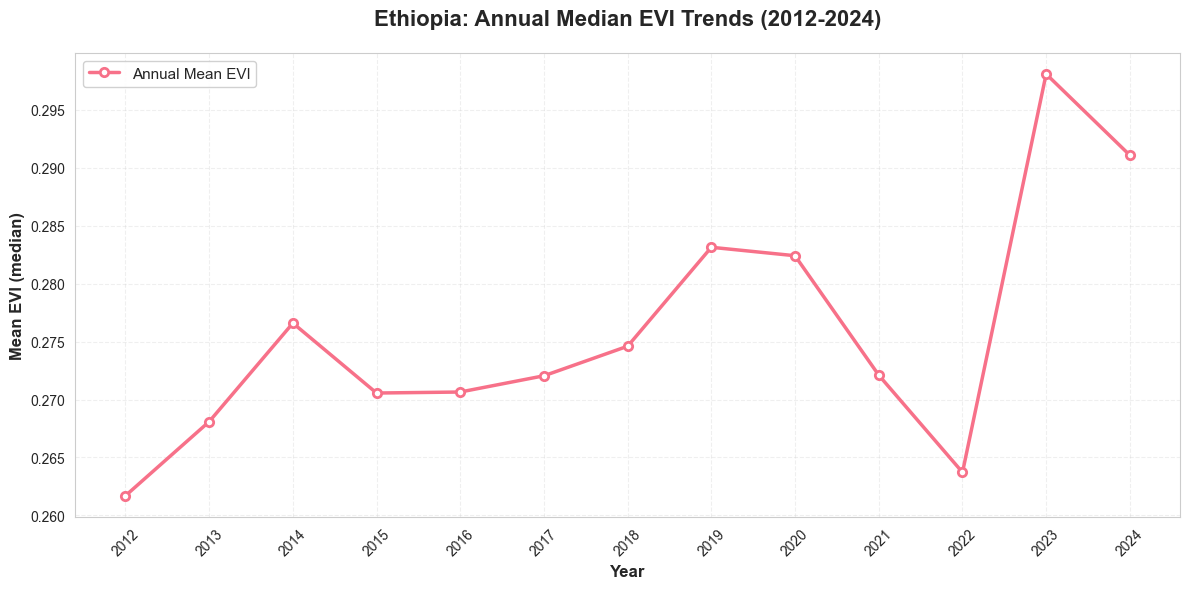

In [128]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data
evi_median_yearly = pd.read_csv('../../data/agriculture/processed/eth_evi_yearly_summary_adm0.csv')
#evi_median_yearly = evi_median_yearly[evi_median_yearly['date']>'2018-01-01']

# Create figure with custom size
plt.figure(figsize=(12, 6))

# Set style
sns.set_style("whitegrid", {"grid.alpha": 0.3})
sns.set_palette("husl")

# Convert date to datetime and set as index
evi_median_yearly['date'] = pd.to_datetime(evi_median_yearly['date'])
evi_median_yearly_indexed = evi_median_yearly.set_index('date')

# Plot with enhanced styling
line = plt.plot(evi_median_yearly_indexed.index, 
                evi_median_yearly_indexed['mean'], 
                linewidth=2.5, 
                marker='o', 
                markersize=6,
                markerfacecolor='white',
                markeredgewidth=2,
                label='Annual Mean EVI')

# Add a subtle fill under the line
# plt.fill_between(evi_median_yearly_indexed.index, 
#                 evi_median_yearly_indexed['mean'], 
#                 alpha=0.1, 
#                 color=line[0].get_color())

# Customize the plot
plt.title('Ethiopia: Annual Median EVI Trends (2012-2024)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Mean EVI (median)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', frameon=True, framealpha=0.9, fontsize=11)

# Format x-axis dates
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Add subtle trend line (optional)
# from scipy import stats
# x = range(len(evi_median_yearly_indexed))
# slope, intercept, r_value, p_value, std_err = stats.linregress(x, evi_median_yearly_indexed['mean'])
# line_fitted = [intercept + slope * i for i in x]
# plt.plot(evi_median_yearly_indexed.index, line_fitted, 'k--', alpha=0.5, linewidth=1, label=f'Trend (R² = {r_value**2:.3f})')
# plt.legend(loc='best', frameon=True, framealpha=0.9, fontsize=11)
# plt.annotate('Event name', xy=(2018, 0.4), xytext=(2017, 0.45),
#              arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
#              fontsize=10, color='red')
# Adjust layout
plt.tight_layout()

# Optional: Add annotation for significant events


# Show the plot
plt.show()


**There is an increasing trend in EVI in Ethiopia since 2012.** However, the dip during the Tigray war and now during the Amhara war is evident. 

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import ipywidgets as widgets
from IPython.display import display

# Function to add trend line to a subplot
def add_trend_line(ax, x_data, y_data, color='grey'):
    """
    Add a linear trend line to the given axis.
    
    Parameters:
    - ax: matplotlib axis to plot on
    - x_data: datetime array for x-axis
    - y_data: EVI values array for y-axis
    - color: color of the trend line
    
    Returns:
    - line: the plotted line object
    """
    # Convert dates to numbers for regression
    x_numeric = mdates.date2num(x_data)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, y_data)
    
    # Calculate slope per year (instead of per day)
    slope_per_year = slope * 365.25
    
    # Create trend line
    trend_x = np.array([x_numeric.min(), x_numeric.max()])
    trend_y = intercept + slope * trend_x
    
    # Convert x back to dates for plotting
    trend_x_dates = mdates.num2date(trend_x)
    
    # Plot trend line
    line = ax.plot(trend_x_dates, trend_y, color=color, linestyle='--', linewidth=1.5, )
    
    # Add legend with information about the trend
    ax.legend(loc='upper left', fontsize=8)
    
    return line

# Enhanced plotting function with trend line option
def get_trend_plot(evi_median, crop_admin_regions, title, show_trend=False):
    """
    Create EVI time series plots by admin area with optional trend lines.
    
    Parameters:
    - evi_median: DataFrame with columns 'admin_area', 'date', and 'median'
    - crop_admin_regions: List of admin areas to include in the plot
    - title: Plot title
    - show_trend: Boolean indicating whether to show trend lines
    
    Returns:
    - fig: The matplotlib figure object
    """
    # Convert date to datetime
    evi_median['date'] = pd.to_datetime(evi_median['date'])

    # Get unique admin areas
    admin_areas = crop_admin_regions
    n_areas = len(admin_areas)

    # Create figure and subplots
    fig, axes = plt.subplots(n_areas, 1, figsize=(12, 2*n_areas), sharex=True)
    fig.suptitle(title, fontsize=14)

    # Make axes iterable even when there's only one subplot
    if n_areas == 1:
        axes = [axes]

    # Add EVI label on the left side
    fig.text(0.04, 0.5, 'EVI', va='center', rotation='vertical', fontsize=12)
    
    # # Find global min and max values for consistent y-axis scaling
    # all_data = evi_median[evi_median['admin_area'].isin(admin_areas)]
    # global_min = all_data['median'].min()
    # global_max = all_data['median'].max()
    
    # # Add some padding (5% of the range) to the limits to avoid data points touching the edges
    # y_range = global_max - global_min
    # padding = y_range * 0.05
    # y_min = max(0, global_min - padding)  # Ensure we don't go below 0 for EVI
    # y_max = global_max + padding
    
    # # Round y_min down and y_max up to nearest 0.05 for nice tick intervals
    # y_min = np.floor(y_min * 20) / 20  # Round down to nearest 0.05
    # y_max = np.ceil(y_max * 20) / 20   # Round up to nearest 0.05
    
    # # Calculate nice tick intervals (aim for 5-7 ticks)
    # tick_interval = np.round((y_max - y_min) / 6 * 20) / 20  # Round to nearest 0.05
    # tick_interval = max(0.05, tick_interval)  # Ensure minimum interval of 0.05
    # y_ticks = np.arange(y_min, y_max + tick_interval/2, tick_interval)

    # Plot each admin area in its own subplot
    for i, area in enumerate(admin_areas):
        ax = axes[i]
        
        # Filter data for this admin area and sort by date
        area_data = evi_median[evi_median['admin_area'] == area].sort_values('date')
        
        # Plot the data
        ax.plot(area_data['date'], area_data['median'], color='green', linewidth=1.5)
        
        # Add trend line if requested
        if show_trend and len(area_data) > 1:
            add_trend_line(ax, area_data['date'].values, area_data['median'].values)
        
        # Set dynamically calculated y-axis limits and ticks
        # ax.set_ylim(y_min, y_max)
        # ax.set_yticks(y_ticks)
        
        # Add area name as title in the center of the subplot
        ax.set_title(area, fontsize=10, loc='center')
        
        # Add gridlines
        ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.5)
        
        # Remove spines and ticks for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        # Only display y-axis on the left
        ax.yaxis.set_ticks_position('left')

    # Format x-axis to show years
    axes[-1].xaxis.set_major_locator(mdates.YearLocator())
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[-1].tick_params(axis='x', rotation=45)

    # Add source note
    fig.text(0.95, 0.01, 'Source: MODIS Processed', ha='right', fontsize=8)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, left=0.1, bottom=0.1, top=0.95)

    return fig


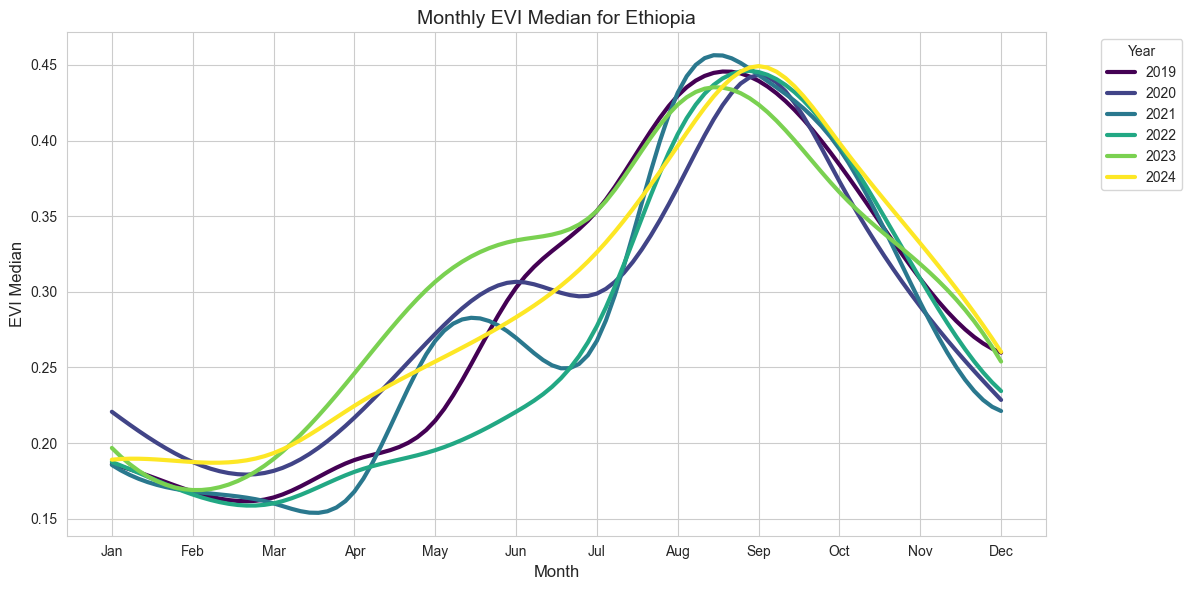

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Using your existing dataframe evi_median_adm0
# Convert date column to datetime if it's not already
evi_median_adm0['date'] = pd.to_datetime(evi_median_adm0['date'])

# Extract year and month from date
evi_median_adm0['year'] = evi_median_adm0['date'].dt.year
evi_median_adm0['month'] = evi_median_adm0['date'].dt.month

# Set figure size and style
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Get unique years to plot each as a separate line
years = sorted([2019,2020,2021,2022,2023,2024])

# Create a color palette with enough colors for all years
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

# Plot each year as a separate smooth line
for i, year in enumerate(years):
    # Filter data for the current year
    year_data = evi_median_adm0[evi_median_adm0['year'] == year]
    
    # Sort by month to ensure correct line connection
    year_data = year_data.sort_values('month')
    
    # Only create smooth lines if we have enough data points
    if len(year_data) >= 4:  # Need at least 4 points for cubic spline
        # Create a smoother x scale with more points
        X_smooth = np.linspace(min(year_data['month']), max(year_data['month']), 100)
        
        # Create the spline function
        spl = make_interp_spline(year_data['month'], year_data['median'], k=3)
        
        # Get smooth y values
        y_smooth = spl(X_smooth)
        
        # Plot only the smoothed line
        plt.plot(X_smooth, y_smooth, 
                linewidth=3,
                label=str(year),
                color=colors[i])
    else:
        # If too few points for spline, use built-in interpolation
        plt.plot(year_data['month'], year_data['median'],
                linewidth=3,
                label=str(year),
                color=colors[i])

# Set x-axis to show month names
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('EVI Median', fontsize=12)
plt.title(f'Monthly EVI Median for {evi_median_adm0["admin_area"].iloc[0]}', fontsize=14)

# Add legend outside the plot
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()

# Uncomment to save the figure
# plt.savefig('evi_monthly_timeseries.png', dpi=300, bbox_inches='tight')

In [136]:
evi_median_annual_adm1 = pd.read_csv('../../data/agriculture/processed/eth_evi_yearly_summary_adm1.csv')
evi_median_annual_adm1.rename(columns={"mean": "median"}, inplace=True)

C:\Users\wb588851\AppData\Local\Temp\ipykernel_13376\765004344.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', fontsize=8)


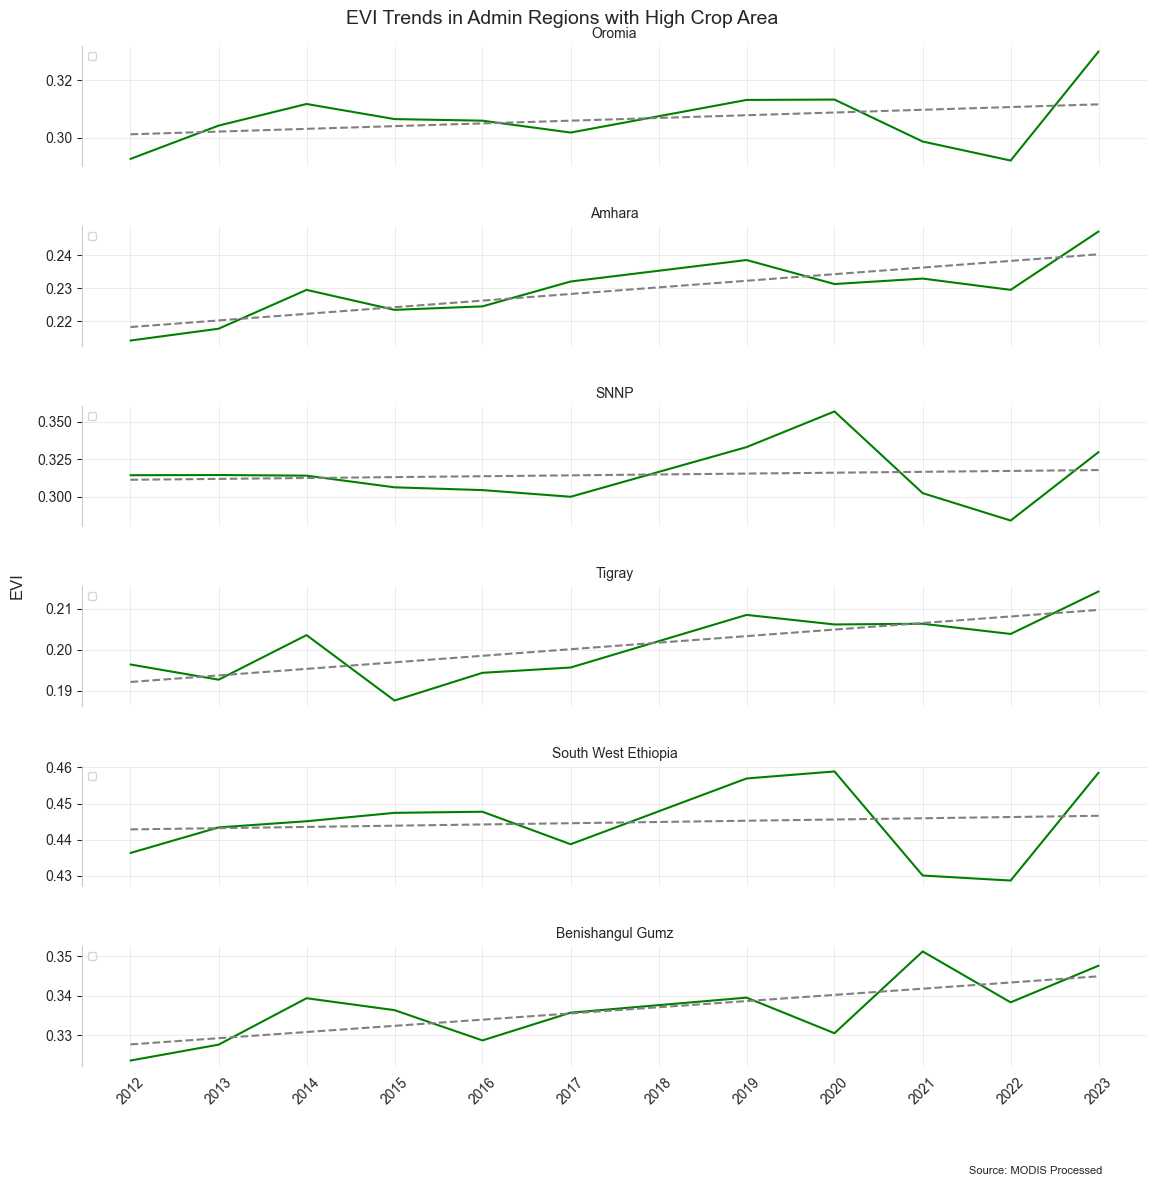

In [150]:
fig = get_trend_plot(evi_median_annual_adm1, crop_admin_regions, 'EVI Trends in Admin Regions with High Crop Area', show_trend=True)

In [88]:
evi_median['month'] = pd.to_datetime(evi_median['date']).dt.month

evi_median['year'] = pd.to_datetime(evi_median['date']).dt.year

In [90]:
evi_median_ref = evi_median[evi_median['date'] < '2023-01-01']
evi_median_ref.loc[:,'month'] = pd.to_datetime(evi_median_ref['date']).dt.month
evi_median_ref = evi_median_ref.groupby(['admin_area', 'month'])['median'].mean().reset_index()
evi_median_ref.rename(columns={'median': 'median_ref'}, inplace=True)

In [91]:
evi_median_adm0_ref = evi_median_adm0[evi_median_adm0['date'] < '2023-01-01']
evi_median_adm0_ref.loc[:,'month'] = pd.to_datetime(evi_median_adm0_ref['date']).dt.month
evi_median_adm0_ref = evi_median_adm0_ref.groupby(['admin_area', 'month'])['median'].mean().reset_index()
evi_median_adm0_ref.rename(columns={'median': 'median_ref'}, inplace=True)

In [63]:
evi_median_adm0['month'] = pd.to_datetime(evi_median_adm0['date']).dt.month

evi_median_adm0['year'] = pd.to_datetime(evi_median_adm0['date']).dt.year